In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from plotly.subplots import make_subplots

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


cluster_top_all_file = "all_cluster_top_motifs.tsv" # top motif per cluster/cell

# Custom Cluster Names
custom_cluster_name_file = "clusters_motif_names.tab.tsv"

diff_dir = "chromvar_diff_v2"
diff_path = Path(diff_dir)

dev_dir = "chromvar_data_v1"
dev_path = Path(dev_dir)

cell_list = ["Astrocytes", "ExNeuron", "InhNeuron", "Microglia", "Oligodendrocytes", "OPC"]
diff_files = [str(diff_path / f"{celltype}_clusters_fdr.tsv") for celltype in cell_list]



# CLUSTERING

In [2]:


# Data Parsing
def get_top_clusters(in_file, num_clusters=None, num_motifs=None, pval_cutoff=None, fdr=False, min_effect=0, min_cluster_size=0):
    """
    Get top clusters from chromvar data
    
    :param num_clusters: Number of clusters to return, Default All
    :param num_motifs: Limit search to number of motifs, Default All
    :param min_effect: Min avg diff a motif in cluster must have
    :param min_cluster_size: Minimum number of motifs in cluster
    """
    
    
    df = pd.read_csv(in_file, sep="\t", index_col=0)
    df["og_rank"] = np.arange(df.shape[0]) + 1 # Retain original chromvar rank
    
    # Get Cluster Counts
    c_counts = df["cluster"].value_counts()
    
    if fdr:
        pcol = "fdr"
    else:
        pcol = "p_val_adj"

    # Get top motifs before filters
    if num_motifs:
        df = df.head(num_motifs)
        
    # Get motifs with minimum pval
    if pval_cutoff is not None:
        df = df.loc[df[pcol] < pval_cutoff, :]
    
    # Get motifs with minimum effect size
    if min_effect > 0:
        df = df.loc[(df["avg_diff"] > min_effect) | (df["avg_diff"] < -min_effect)]
    
    
    # Get clusters with minimum value
    count_filt_clusters = c_counts[c_counts >= min_cluster_size].index.tolist()
    df = df.loc[df["cluster"].isin(count_filt_clusters), :]
    
    
    # SHOULD BEFORE OR AFTER NUM MOTIFS?!
    top_clusters = list(df["cluster"].unique())
    
    # Get top N clusters
    if num_clusters:
        top_clusters = top_clusters[:num_clusters]

    return top_clusters



In [3]:


# Use Cluster Numbers as colorset
def gen_palette_v2(cluster_set, num_cluster_dict=None):

    if not num_cluster_dict:
        cluster_num_file = "jaspar_motifs_per_cluster_2020.tsv"
        
    cluster_dict = pd.read_csv(cluster_num_file, sep="\t", index_col=0)["Number_of_Motifs"].to_dict()
    
    # Get colorscales
    dark_scale = px.colors.qualitative.Dark24
    light_scale = px.colors.qualitative.Light24
    
    # Check sizes and assign color
    cluster_color_list = []
    dark_i = 0
    light_i = 0
    
    for curr_cluster in cluster_set:
        if cluster_dict[curr_cluster] > 5:
            cluster_color_list.append((curr_cluster, dark_scale[dark_i]))
            dark_i += 1
        else:
            cluster_color_list.append((curr_cluster, light_scale[light_i]))
            light_i += 1
    
    # Create color map
    color_map = {cluster:color for cluster, color in cluster_color_list}
    
    return color_map



# VOLCANOS

In [4]:


def make_volcano_data(in_file, fdr=False):
    
    df = pd.read_csv(in_file, sep="\t", index_col=0)
    
    if fdr:
        pcol = "fdr"
        out_col = "log10q"
    else:
        pcol = "p_val_adj"
        out_col = "log10p"

    
    # If any pvalues rounded to 0
    if (df[pcol] == 0).any():
        nonzero_min = (df.loc[df[pcol] > 0, pcol]).min()
        df.loc[df[pcol] == 0, pcol] = nonzero_min
    
    df[out_col] = -np.log10(df[pcol], where=df[pcol] > 0) # -log10p
    
    return df



In [5]:


def plot_volcano_clusters(df, top_clusters, cutoff=0.05, num_motifs=None, show_plot=False, plot_title=None, custom_cmap=None, cluster_labels=None):
    
    if not plot_title:
        plot_title = "Avg-Diff vs -log10p Value"
    
    # Check if FDR-Corrected
    if (df.columns[-1] == "log10q") or ("log10q" in df.columns):
        p_col = "log10q"
        p_text = "-log(10)Q"
    else:
        p_col = "log10p"
        p_text = "-log(10)P"
    
    
    min_diff = df["avg_diff"].min()
    max_diff = df["avg_diff"].max()

    # compute range for x-axis
    max_range = np.max([int(abs(min_diff)), int(abs(max_diff))]) + 1
    
    # Get pvalue cutoff
    log_cutoff = -np.log10(cutoff)
    
    
    # Get cluster color
    df["cluster_name"] = np.where(df["cluster"].isin(top_clusters), df["cluster"], "Other-Cluster")

    
    # ONLY COLOR TOP NUM MOTIFS
    if num_motifs:
        df.iloc[num_motifs:, df.columns.get_loc("cluster_name")] = "Other-Cluster"
    
    
    # Make color map and order
    c_order = list(df["cluster_name"].unique())
    c_order.pop(c_order.index("Other-Cluster"))
    c_order.append("Other-Cluster")
    
    if custom_cmap:
        cmap = {}
        
        for cluster, color in custom_cmap.items():
            cmap[cluster] = color
            
        cmap["Other-Cluster"] = "gray"
    else:
        num_clusters = len(top_clusters)
        cmap = {cluster: color for cluster, color in
                zip(c_order[:num_clusters], px.colors.qualitative.Plotly[:num_clusters])}
        
        cmap["Other-Cluster"] = "gray"
    
    
    # If legend labels not provided
    if cluster_labels is not None:

        # Add new name to colormap
        for cluster, new_label in cluster_labels.items():
            
            if cluster in cmap:
                cmap[new_label] = cmap[cluster]
        
        
        # Update Cluster order w/ new labels
        c_order = [cluster_labels[cluster] for cluster in c_order
                   if cluster in cluster_labels]
        c_order.append("Other-Cluster")
        
        # Rename Clusters according to labels
        cluster_labels["Other-Cluster"] = "Other-Cluster"
        df["cluster_name"] = df["cluster_name"].map(cluster_labels)
    
    
    # Reverse c_order
    c_order = c_order[::-1]

    # Create fig
    fig = px.scatter(df, x="avg_diff", y=p_col,
                     range_x=[-max_range, max_range],
                     color="cluster_name", color_discrete_map=cmap,
                     category_orders={"cluster_name": c_order},
                     hover_data={"motif_name": True, "cluster": True},
                     title=plot_title, width=800, height=600)

    
    fig.add_hline(y=log_cutoff, line_dash="dash", line_width=1, opacity=0.7,
                  annotation_text=f"{p_text}: {round(log_cutoff, 2)}", annotation_position="bottom right")

    
    # Update layout
    fig.update_layout(title={"font_size": 18, "x": 0.5, "y": 0.9,
                             "xanchor": "center", "yanchor": "top"},
                      legend={"title": "Clusters", "traceorder": "reversed"},
                      plot_bgcolor="white"
                     )
    
    fig.update_xaxes(title_text="Avg Difference")
    fig.update_yaxes(title_text=p_text, gridcolor="lightgray")
    
    
    fig.update_traces(marker_size=4.5)

    if show_plot:
        fig.show()

    
    return fig





# HEATMAPS





In [6]:


def merge_cluster_data(file_list, cell_list, top_clusters, fdr=False, effect_order=True, out_top_motif=False):
    """
    :param effect_order: Effect order instead of rank
    :param out_rank: return given ranks (return_ranks output from combine_top_clusters)
    :type out_rank: list of lists (Ordered cell_list x Ascending Rank)
    """
    
    cluster_df = pd.DataFrame({"cluster": list(top_clusters)})
    
    # Sort by cluster number
    cluster_df["cluster_num"] = cluster_df["cluster"].str.split("_", expand=True)[1]
    cluster_df = cluster_df.astype({"cluster_num": "int"})
    cluster_df = cluster_df.sort_values(by="cluster_num").drop(columns=["cluster_num"])

    dev_df = cluster_df.copy(deep=True)

    top_motif_df = cluster_df.copy(deep=True)
    
    
    # If using fdr or p_val_adj
    if fdr:
        pcol = "fdr"
    else:
        pcol = "p_val_adj"

        
    for cell, in_file in zip(cell_list, file_list):
        df = pd.read_csv(in_file, sep="\t", index_col=0)
        
        if effect_order:
            df["abs_avg_diff"] = abs(df["avg_diff"])
            df = df.sort_values(by=["abs_avg_diff"], ascending=False)
        
        
        if (df[pcol] == 0).any():
            nonzero_min = (df.loc[df[pcol] > 0, pcol]).min()
            df.loc[df[pcol] == 0, pcol] = nonzero_min
        
        df["log10p"] = abs(-np.log10(df[pcol], where=df[pcol] > 0)) # -log10p
        
        df = df.loc[df["cluster"].isin(top_clusters), :]
        
        # Max Pval and most sig avg diff. method
        top_df = df.drop_duplicates(subset="cluster", keep="first")
        
        cluster_df = cluster_df.merge(top_df[["cluster", "log10p"]],
                                      on="cluster").rename(columns={"log10p": cell})
        
        dev_df = dev_df.merge(top_df[["cluster", "avg_diff"]],
                              on="cluster").rename(columns={"avg_diff": cell})
        
        top_motif_df = top_motif_df.merge(top_df[["cluster", "motif_name"]],
                                          on="cluster").rename(columns={"motif_name": cell})


    # Set as index instead of column
    cluster_df = cluster_df.set_index("cluster")
    dev_df = dev_df.set_index("cluster")
    return_data = [cluster_df, dev_df]
    
    if out_top_motif:
        top_motif_df = top_motif_df.set_index("cluster")
        return_data.append(top_motif_df)
    
    return return_data


def get_cluster_annot_data(sig_df, dev_df, top_cluster_dict, central_dict, cluster_order=None, alpha=False):
    
    if cluster_order is not None:
        sig_df = sig_df.reindex(cluster_order)
        dev_df = dev_df.reindex(cluster_order)
    
    sig_df.index = sig_df.index.map(central_dict)
    dev_df.index = dev_df.index.map(central_dict)

    if alpha:
        sig_df = sig_df.sort_index()
        dev_df = dev_df.sort_index()
    
    return sig_df, dev_df



In [7]:


def plot_heatmap_dendro(sig_df, dev_df, cutoff=0.05, only_sig=True, plot_title=None, show_pval=False, show_plot=True):
    
    if not plot_title:
        plot_title = "Motif Cluster Enrichment per Cell-Type"
        
    # Make datasets
    sig_data = sig_df.to_numpy().T
    dev_data = dev_df.to_numpy().T
    cell_names = list(dev_df.columns)
    cluster_labels = list(dev_df.index)
    
    
    # Make formatted array for heatmap
    sig_display_text = [[np.format_float_positional(i, precision=2, unique=False, fractional=False, trim='-')
                         for i in row] for row in sig_data]

    dev_display_text = [[np.format_float_positional(i, precision=2, unique=False, fractional=False, trim='0')
                         for i in row] for row in dev_data]

    # Create Merged Figure
    merged_fig = make_subplots(rows=2, cols=1, vertical_spacing=0, shared_xaxes=True, row_heights=[0.2, 0.8])

    # Make dendro
    dendro_fig = ff.create_dendrogram(dev_df.to_numpy(), orientation="bottom",
                                      labels=cluster_labels, color_threshold=0, colorscale=["#7f7f7f"])

    for data in dendro_fig['data']:
        merged_fig.add_trace(data, row=1, col=1)
    
    # Get dendrogram axis for heatmap
    dendro_ticks = dendro_fig['layout']['xaxis']['tickvals']
    dendro_axis = list(map(int, dendro_ticks))

    # Add Heatmap
    heat_fig = go.Heatmap(x=dendro_axis, y=cell_names, z=dev_data, text=dev_display_text,
                          texttemplate="%{text}", textfont={"size":10.7},
                          colorbar={"title": "Avg. Diff"},
                          zmin=-1, zmid=0, zmax=1, colorscale="RdBu_r",
                          xgap=2, ygap=2)


    merged_fig.add_trace(heat_fig, row=2, col=1)
    
    # Update Y axis data
    merged_fig.update_yaxes(visible=False, row=1, col=1)
    merged_fig.update_yaxes(visible=True, title="Cell-Type", title_font_size=18, tickfont_size=12, ticks="outside", autorange="reversed", row=2, col=1)

    # Update X axis data
    merged_fig.update_xaxes(tickvals=dendro_ticks, ticktext=cluster_labels, ticks="outside", title="Motif-Cluster", title_font_size=18, row=2, col=1)


    merged_fig.update_layout(height=800, width=1600, showlegend=False,
                             title={"text": plot_title, "font_size": 22,
                                    "x": 0.5, "y": 0.95, "xanchor": "center", "yanchor": "middle"},
                             margin={"t": 80}, plot_bgcolor="white"
                            )
    

    # Cover Nonsig with grey
    if only_sig:
        row_i, col_i = np.where(sig_data < -np.log10(cutoff))

        for row, col in zip(row_i, col_i):
            merged_fig.add_shape(type="rect", x0=(col*10), y0=row-0.5,
                                 x1=(col*10)+10, y1=(row-0.5)+1,
                                 line=dict(color="white"),
                                 fillcolor="lightgray",
                                 row=2, col=1
                                )
    
    
    # SHOW SIG VALUES
    if show_pval:
        log_cutoff = -np.log10(cutoff)

        for row_i, row_data in enumerate(sig_data):
            for col_i, pval in enumerate(row_data):

                if pval > log_cutoff:

                    # Get formatted
                    p_text = sig_display_text[row_i][col_i]

                    if abs(round(dev_data[row_i, col_i], 2)) < 0.61:
                        text_color = "black"
                    else:
                        text_color = "white"


                    merged_fig.add_annotation(x=(col_i*10)+5, y=row_i+0.18, xref="x", yref="y",
                                              text=f"({p_text})", showarrow=False,
                                              xanchor="center", yanchor="middle",
                                              font_size=10.7, font_color=text_color,
                                              row=2, col=1)
    
    
    if show_plot:
        merged_fig.show()
    
    
    return merged_fig
    


# TEST PLOTTING

In [8]:

def rename_top_clusters(cluster_dict):
    
    renamed_dict = {}
    for cluster, motif in cluster_dict.items():
        
        # Ignore Other-Cluster
        if cluster == "Other-Cluster":
            renamed_dict[cluster] = motif
            continue
        
        # Remove var
        if "var." in motif:
            motif = motif.split("(")[0]
        
        # Get cluster num
        c_num = cluster.split("_")[-1]
        
        renamed_dict[cluster] = f"C{c_num}({motif})"
        
    return renamed_dict


def rename_clusters_custom(custom_file):
    
    df = pd.read_csv(custom_file, sep="\t", header=0, usecols=[0, 1], names=["cluster", "label"])
    
    # Get Cluster Name
    df["cluster_num"] = df["cluster"].str.split("_", expand=True)[1]
    
    # Re-label
    df["new_label"] = df["label"] + " [" + df["cluster_num"] + "]"
    
    # Create Dictionary
    rename_dict = df.set_index("cluster")["new_label"].to_dict()
    
    return rename_dict



In [11]:


# PLOT OUT PATH
out_path = Path("plots/final_drafts")
out_path_main = out_path / "main_v3"
out_path_supp = out_path / "supp_v3"

out_path_main.mkdir(parents=True, exist_ok=True)
out_path_supp.mkdir(parents=True, exist_ok=True)

# cell_list alternatives
main_cells = ["ExNeuron", "InhNeuron", "Oligodendrocytes"]
other_cells = ["Astrocytes", "Microglia", "OPC"]


# Top motif per cluster/cell
top_all_df = pd.read_csv(cluster_top_all_file, sep="\t", index_col=0)


# Generate label dictionary
label_dict = pd.read_csv(custom_cluster_name_file, sep="\t",
                         index_col=0, header=0, usecols=[0, 1],
                         names=["cluster", "label"])["label"].to_dict()


# Parameters and vars for set creation
cluster_dict = {}

cluster_list = []
main_clusters = []
other_clusters = []

num_motifs = 50

for celltype in cell_list:
    test_file = str(diff_path / f"{celltype}_clusters_fdr.tsv")

    # Rank and size based clusters
    top_clusters = get_top_clusters(test_file, num_clusters=None, fdr=True, num_motifs=num_motifs, pval_cutoff=0.1)
    
    # Save top clusters per celltype
    cluster_dict[celltype] = top_clusters

    
    for curr_cluster in top_clusters:
        
        if curr_cluster not in cluster_list:
            cluster_list.append(curr_cluster)
        
        if (celltype in main_cells) and (curr_cluster not in main_clusters):
            main_clusters.append(curr_cluster)

        elif (celltype in other_cells) and (curr_cluster not in other_clusters):
            other_clusters.append(curr_cluster)



# Generate custom color palette
custom_cmap = gen_palette_v2(cluster_list)

main_cmap = gen_palette_v2(main_clusters)
other_cmap = gen_palette_v2(other_clusters)



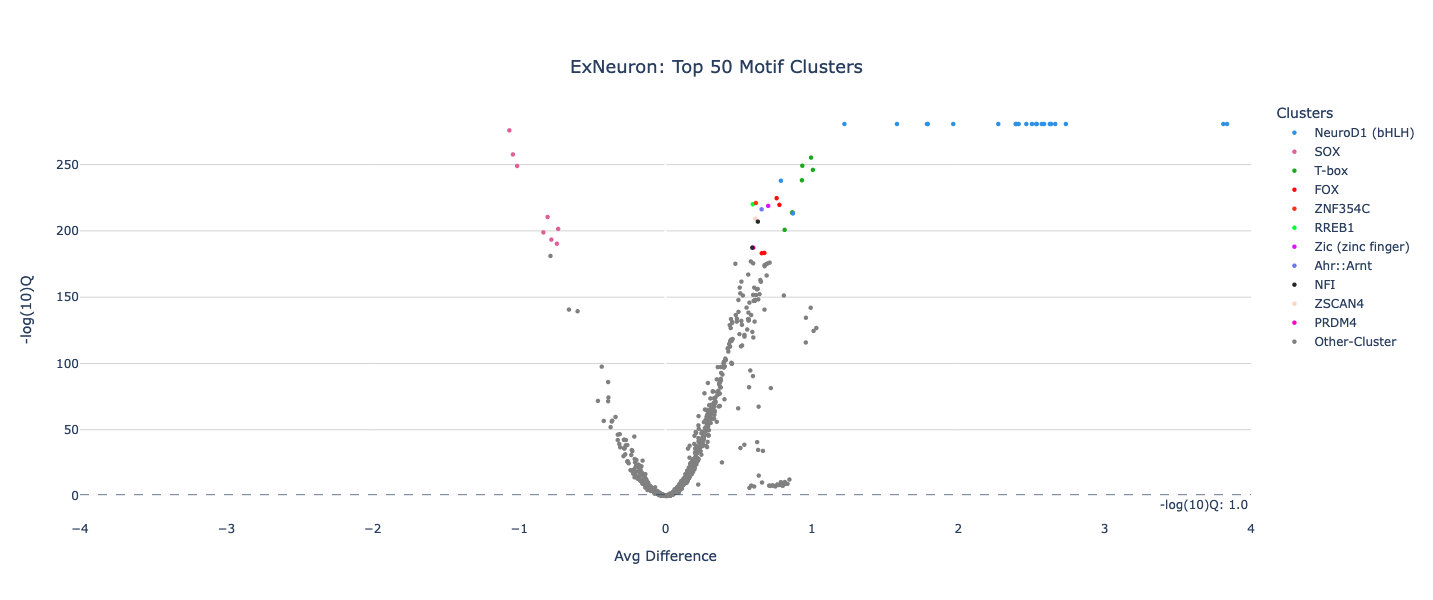

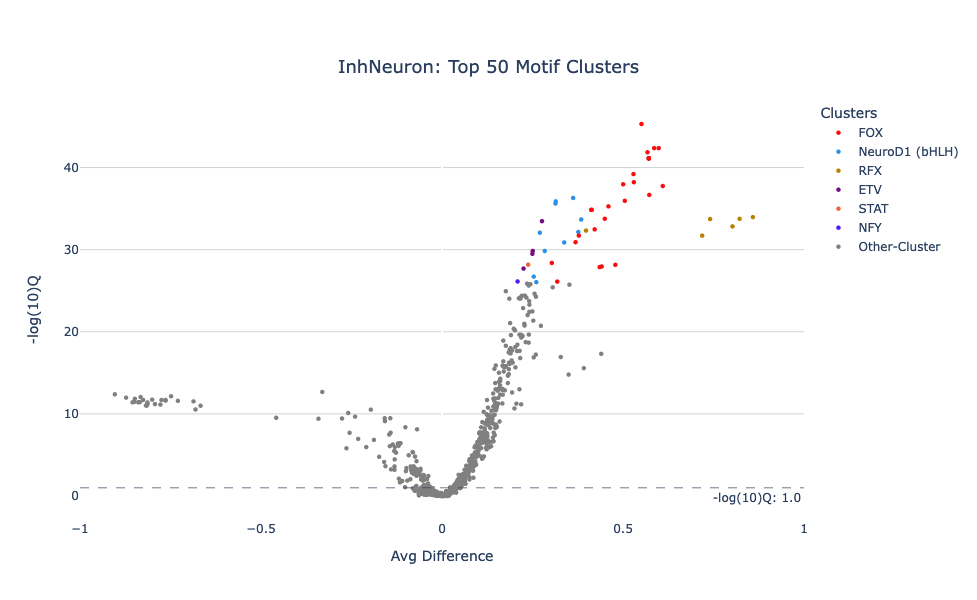

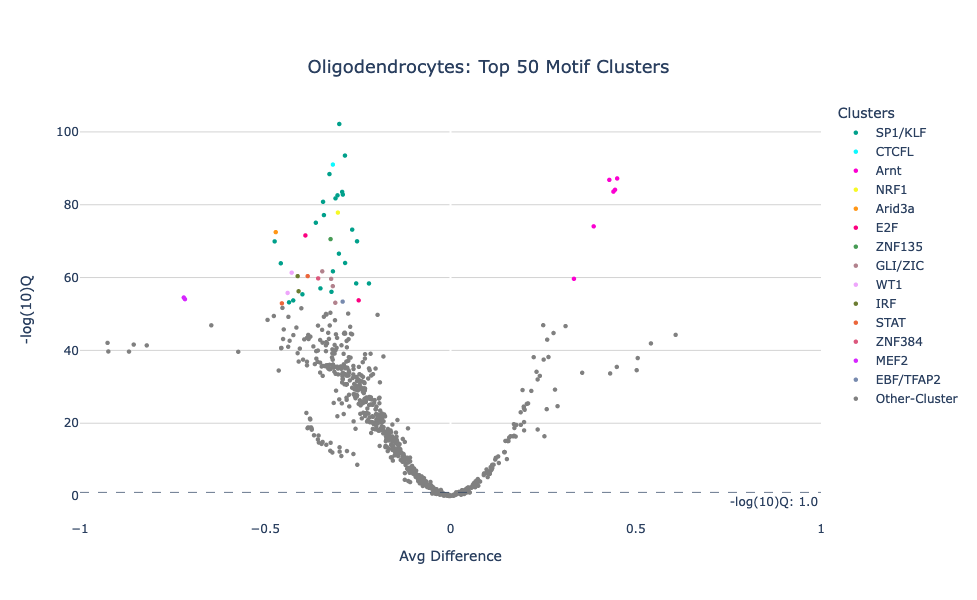

In [12]:
"""
Volcano Plots

Label Options: Cell Top, ALL Top, Central
Color Options: Unified across main cells, Separate Colors for main & supp

"""

for celltype, top_clusters in cluster_dict.items():
    
    if celltype not in main_cells: # Show main only, for simplicity
        continue
    
    
    in_file = str(diff_path / f"{celltype}_clusters_fdr.tsv")
    out_file = str(out_path_main / f"{celltype}_chromvar_volcano_v3.pdf")
    
    in_df = make_volcano_data(in_file, fdr=True)

    
    cell_top_dict = top_all_df[celltype].to_dict()
    
    main_volcano_fig = plot_volcano_clusters(in_df, top_clusters, 
                                             num_motifs=num_motifs, cutoff=0.1, show_plot=True,
                                             custom_cmap=main_cmap, cluster_labels=label_dict,
                                             plot_title=f"{celltype}: Top {num_motifs} Motif Clusters"
                                            )
    
    main_volcano_fig.write_image(out_file, format="pdf")



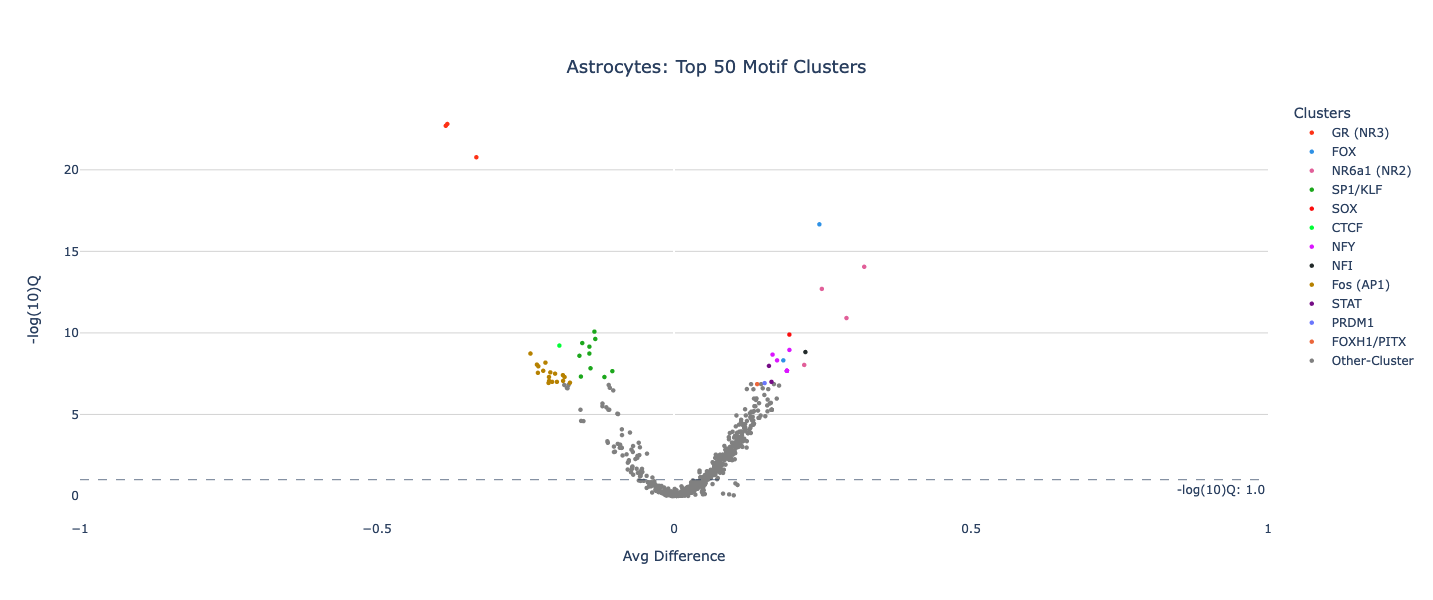

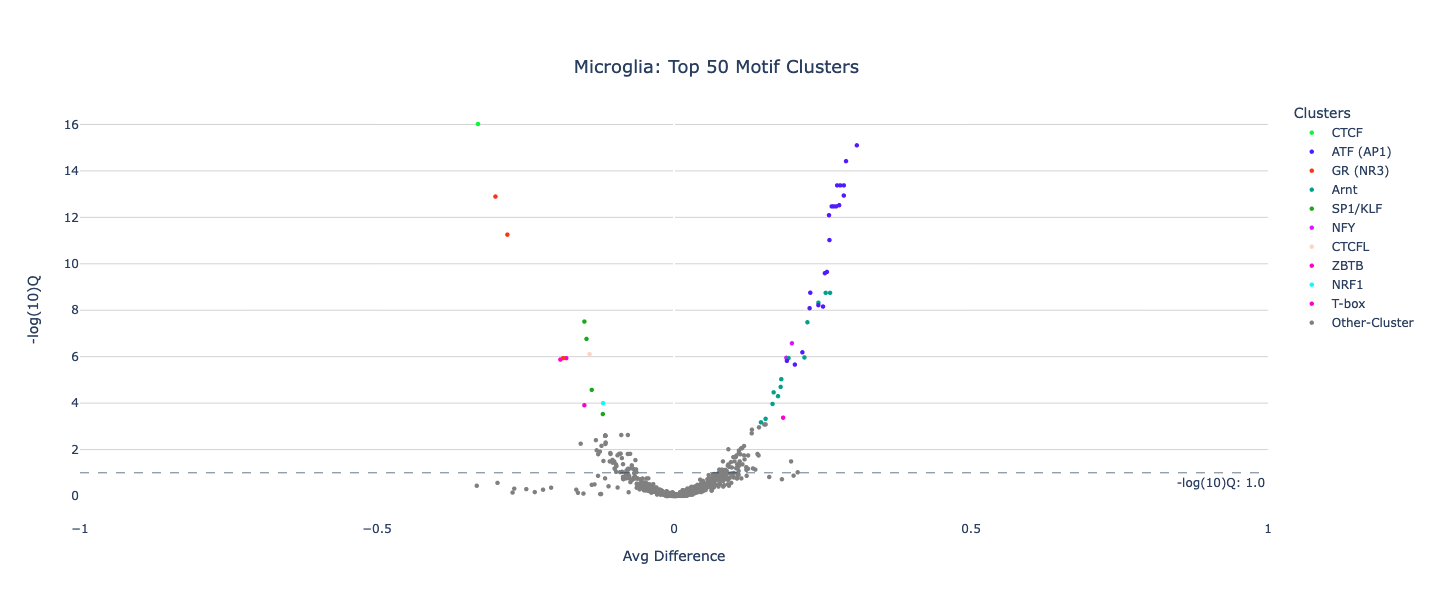

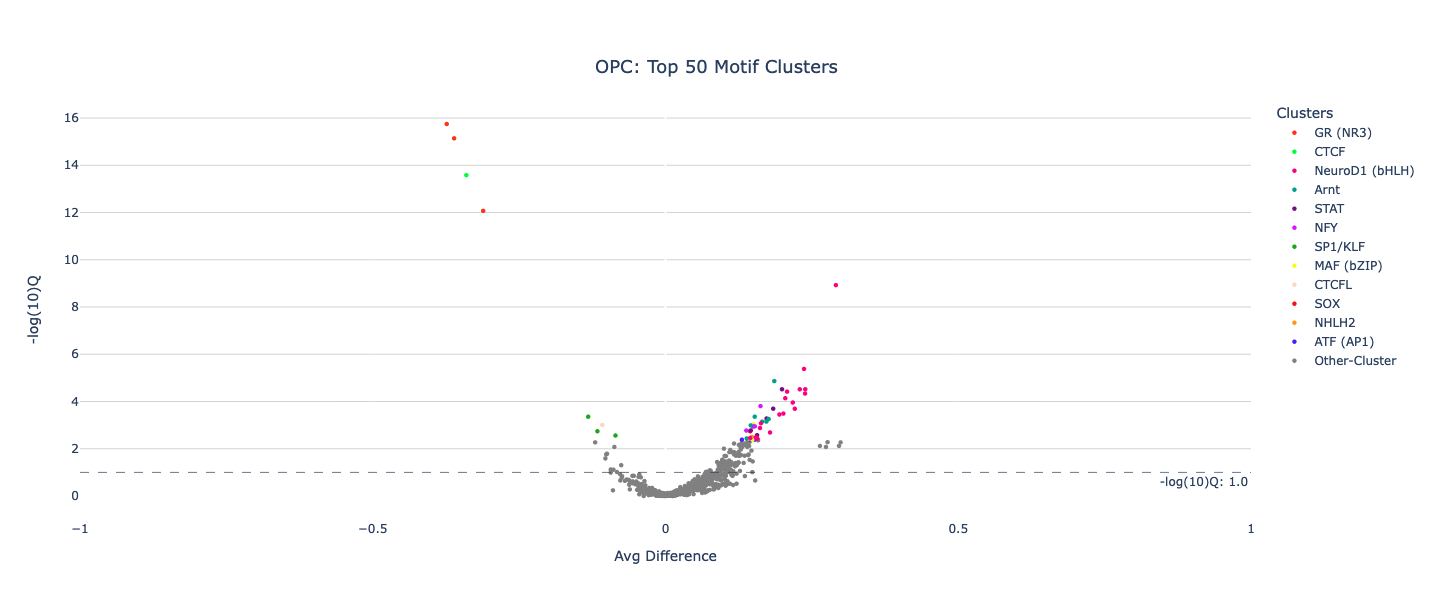

In [13]:


# Supplementary Volcano Plots
for celltype, top_clusters in cluster_dict.items():
    
    if celltype not in other_cells: # Show supplementary only
        continue
    
    in_file = str(diff_path / f"{celltype}_clusters_fdr.tsv")
    out_file = str(out_path_supp / f"{celltype}_chromvar_volcano_v3.pdf")
    
    in_df = make_volcano_data(in_file, fdr=True)

    
    cell_top_dict = top_all_df[celltype].to_dict()
    
    supp_volcano_fig = plot_volcano_clusters(in_df, top_clusters,
                                             num_motifs=num_motifs, cutoff=0.1, show_plot=True,
                                             custom_cmap=other_cmap, cluster_labels=label_dict,
                                             plot_title=f"{celltype}: Top {num_motifs} Motif Clusters"
                                            )
    
    supp_volcano_fig.write_image(out_file, format="pdf")



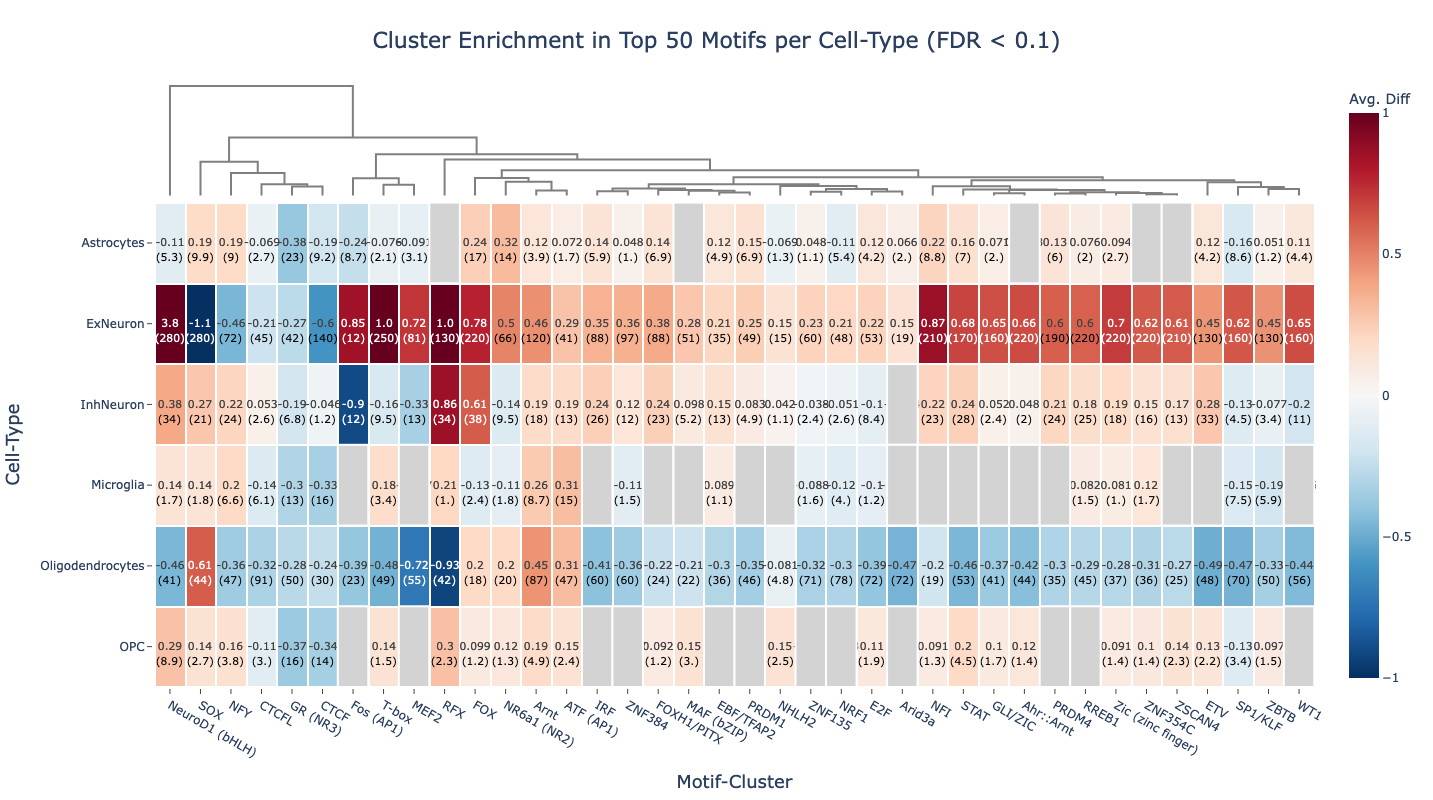

In [14]:

# Test Dendro heatmap func

# Get initial data and ordering
sig_df, dev_df, top_df = merge_cluster_data(diff_files, cell_list, cluster_list, fdr=True, out_top_motif=True)


# Get Dendrogram order
dendro_order = ff.create_dendrogram(dev_df.to_numpy(), orientation="bottom", labels=dev_df.index)['layout']['xaxis']['ticktext']

# Update data to use in figures
top_sig_df, top_dev_df = get_cluster_annot_data(sig_df, dev_df, cluster_dict, label_dict, cluster_order=dendro_order, alpha=False)


# Plot Dendrograms
heatmap_fig = plot_heatmap_dendro(top_sig_df, top_dev_df, cutoff=0.1,
                                  plot_title="Cluster Enrichment in Top 50 Motifs per Cell-Type (FDR < 0.1)",
                                  only_sig=True, show_pval=True, show_plot=True)

# Write out
out_file = str(out_path_main / "chromvar_heatmap_v3.pdf")
heatmap_fig.write_image(out_file, format="pdf")

